In [ ]:
!pip install -q sentence-transformers
!pip install -q umap-learn

In [ ]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from scipy import spatial
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import umap
from sentence_transformers import SentenceTransformer
from bs4 import BeautifulSoup
from datetime import datetime

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
path = "/content/drive/MyDrive/NYU-Tandon_Bridge/"
# Import raw json data
#with open(path+"'Piazza Data'/'Summer 2020 (24 Weeks)'/piazza_posts_data.csv", "r") as f:
#    raw_transcript = json.load(f)
df_posts = pd.read_csv('/content/drive/MyDrive/data/tandon_bridge/data/piazza/piazza_posts_data.csv')
df_followups = pd.read_csv('/content/drive/MyDrive/data/tandon_bridge/data/piazza/piazza_followups_data.csv')

In [ ]:
df_posts['type'] = 'post'

In [ ]:
df_posts.head()

,Unnamed: 0,anon,uid,subject,created,content,post_id,is_instructor,uid_a,unique_id,length,length_cont,length_subj,type
0,0,no,jqjrav14ehv5px,"Indu Office Hours Tomorrow (Wed), 8:00pm",2020-12-15T23:25:00Z,"<p>Hi everyone, I&#39;m doing office hours tom...",kiqm5i2z9sr59d,True,NaN,kiqm5i2z9sr59d,162,122,40,post
1,1,no,jrleouqzv0p38x,Exam 4 Review Session,2020-12-14T04:30:22Z,We will hold an Exam 4 Review Session on Tuesd...,kinbscfohpv2gw,True,NaN,kinbscfohpv2gw,241,220,21,post
2,2,no,jrleouqzv0p38x,HW19 graded,2020-12-12T04:26:06Z,<p>Statistics:<br /> Minimum: 80.0<br /> Max...,kil75hfuiaq6dv,True,NaN,kil75hfuiaq6dv,164,153,11,post
3,3,no,jrleouqzv0p38x,practice_exam_4.pdf has been added to class re...,2020-12-11T18:44:03Z,"<p>Practice exam 4, both with and without solu...",kikmcylylgq3z0,True,NaN,kikmcylylgq3z0,687,605,82,post
4,4,no,jrleouqzv0p38x,HW16 grades released,2020-11-16T19:12:14Z,<p>Statistics:<br /> Minimum: -50.0<br /> Ma...,khkxcw8kfcw2b0,True,NaN,khkxcw8kfcw2b0,175,155,20,post


In [ ]:
df_followups.head()

,Unnamed: 0,post_id,followup_id,followup_level,anon,subject,data,created,type,uid,is_instructor,content,unique_id,length_subj,length_cont,length
0,0,kiqm5i2z9sr59d,kiqn9oawib35f7,1,no,<p>thanks indu! </p>,NaN,2020-12-15T23:56:07Z,followup,kccpr2zaayq2i8,False,NaN,kiqn9oawib35f7,20,0,20
1,1,kiqm5i2z9sr59d,kiqnx4swc0d1wr,2,no,<p>you&#39;re welcome :) </p>,NaN,2020-12-16T00:14:21Z,feedback,jqjrav14ehv5px,True,NaN,kiqnx4swc0d1wr,29,0,29
2,2,kinbscfohpv2gw,kiquh9odhyq725,1,no,"<p>Hi,</p>\n<p> Is there a way to watch the ...",NaN,2020-12-16T03:17:58Z,followup,kccprc7jxli2uy,False,NaN,kiquh9odhyq725,130,0,130
3,3,kinbscfohpv2gw,kiqukzuame57in,2,no,<p>It is recorded in the Zoom section of NYU C...,NaN,2020-12-16T03:20:52Z,feedback,k54tq3hzuyo33f,False,NaN,kiqukzuame57in,57,0,57
4,4,kinbscfohpv2gw,kiqx0mcfdvt26r,2,no,<p>Do I need to use my nyu@email to get access...,NaN,2020-12-16T04:29:00Z,feedback,kccprc7jxli2uy,False,NaN,kiqx0mcfdvt26r,63,0,63


In [ ]:
# --- Data Preprocessing ------------------------------------------------------

# # Init Spacy
# nlp = spacy.load('en_core_web_lg')
# Define the stop words list
stop_words = set(stopwords.words('english'))
# Define stemmer
stemmer = PorterStemmer()
# Define lemmatizer
lemmatizer = WordNetLemmatizer()
# Define tf-idf vectorizer
vectorizer = TfidfVectorizer()


# Text preprocessing pipeline for the model
def text_preprocessing_1(lines):
    # remove html tags
    soup = BeautifulSoup(str(lines))
    lines = soup.get_text()
    lines = lines.lower()
    lines = re.sub('[\r\n]+', ' ', lines)
    lines = re.sub('[\xa0]+', '', lines)
    return lines


# Converts raw data to dataframe where each doc is a slide or transcript para
def clean_dataframe(df, text_col):
    df.dropna(subset=[text_col], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df[text_col] = df[text_col].apply(text_preprocessing_1)
    return df


# df_posts = df_posts[['uid', 'content']]
# df_followups = df_followups[['uid', 'subject']]

# Apply conversion
df_posts = clean_dataframe(df_posts, "content")
df_followups = clean_dataframe(df_followups, "subject")





In [ ]:
df_posts = df_posts[['unique_id', 'uid', 'created', 'type', 'is_instructor', 'anon', 'subject', 'content']]
df_followups = df_followups[['unique_id', 'uid', 'created', 'type', 'is_instructor', 'anon', 'subject', 'content']]

In [ ]:
# df_posts['text'] = df_posts['content']
# df_followups['text'] = df_followups['subject']
# df_posts.drop('content', inplace=True, axis=1)
# df_followups.drop('subject', inplace=True, axis=1)

### Preprocess the combined data

In [ ]:
df = pd.concat([df_posts, df_followups])
# Keep only non anonymous students and remove instructors - 1511 rows/participations
# df = df[df['anon'] == 'no']
df = df[df['is_instructor'] == False]
# Convert datetime
df['created'] =  pd.to_datetime(df['created'], )
# Sort by time and reset index
df.sort_values(by=['created'], inplace=True, ascending=True)
df.reset_index(drop=True, inplace=True)
# Replace nan in subject and content
df['content'] = df['content'].replace(np.nan, '', regex=True)
df['subject'] = df['subject'].replace(np.nan, '', regex=True)

In [ ]:
df.head(20)

,unique_id,uid,created,type,is_instructor,anon,subject,content
0,kcaz653v7u666u,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Search for Teammates!,"pa.load(""/dashboard/project_partners"", null, f..."
1,kcaz64zljpq66k,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Get familiar with Piazza,"pa.load(""/dashboard/get_familiar"", null, funct..."
2,kcaz6506lfv66m,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Introduce Piazza to your students,"pa.load(""/dashboard/introduce_piazza"", null, f..."
3,kcaz64xhuj166f,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Welcome to Piazza!,piazza is a q&a platform designed to get you g...
4,kcaz64z2b5w66i,gd6v7134AUa,2020-07-06 20:46:44+00:00,post,False,no,Tips & Tricks for a successful class,"pa.load(""/dashboard/tips_tricks"", null, functi..."
5,kccogf1gfio1du,k54tq3bfrqt336,2020-07-08 01:22:20+00:00,post,False,no,NYU Bridge Contact Sheet Summer 2020,"hi, i created a contact sheet using my nyu goo..."
6,kccp0cavwhw5yi,jxqfcqrsvtv7nn,2020-07-08 01:37:50+00:00,followup,False,no,"hi domenick, some one on the slack channel alr...",
7,kccp6j4t71zuq,kccopj3l12mrx,2020-07-08 01:42:39+00:00,followup,False,no,do you have any suggestions for helpful extens...,
8,kccq3xk141v6hp,k54tq3bfrqt336,2020-07-08 02:08:37+00:00,feedback,False,no,"malaika, thank you. i added my contact info to...",
9,kccx39ks10z4lw,kccprh82f0c32p,2020-07-08 05:24:03+00:00,post,False,no,No permission to review today&#39;s zoom recor...,i used my nyu g suite account to log in zoom a...


In [ ]:
date_exam_1 = datetime.fromisoformat('2020-08-14T23:59:59Z+00:00')
date_exam_2 = datetime.fromisoformat('2020-09-25T23:59:59Z+00:00')
date_exam_3 = datetime.fromisoformat('2020-11-13T23:59:59Z+00:00')
date_exam_4 = datetime.fromisoformat('2020-12-18T23:59:59Z+00:00')

In [ ]:
# Split into exams
e1 = df[df['created'] <= date_exam_1]
e2 = df[(date_exam_1 < df['created']) & (df['created'] <= date_exam_2)]
e3 = df[(date_exam_2 < df['created']) & (df['created'] <= date_exam_3)]
e4 = df[(date_exam_3 < df['created']) & (df['created'] <= date_exam_4)]

## STATISTICS

In [ ]:
exam_labels = ['Exam 1', 'Exam 2', 'Exam 3', 'Exam 4']

In [ ]:
# Count of overall piazza participations (posts, followups, feedbacks)
stat_1 = [len(e1), len(e2), len(e3), len(e4)] #stat_1_participation_counts

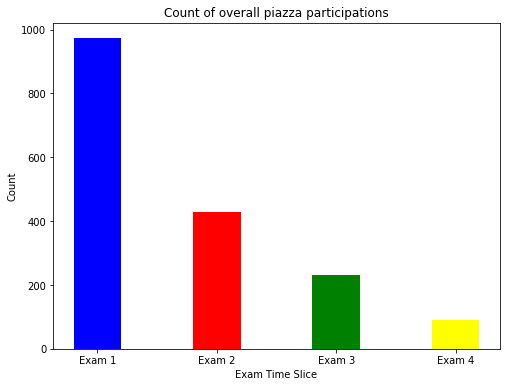

In [ ]:
fig = plt.figure(figsize = (8, 6))
plt.bar(exam_labels, stat_1, width = 0.4, color=['blue', 'red', 'green', 'yellow'])
plt.xlabel("Exam Time Slice")
plt.ylabel("Count")
plt.title("Count of overall piazza participations")
plt.show()

In [ ]:
# Count of unique students that participated on piazza
stat_2 = [len(set(e1['uid'].to_list())), 
          len(set(e2['uid'].to_list())), 
          len(set(e3['uid'].to_list())), 
          len(set(e4['uid'].to_list()))
          ] #stat_2_unique_students

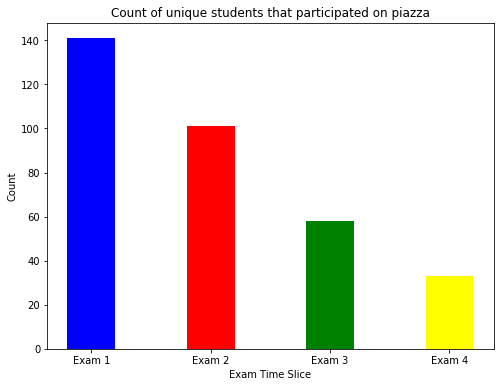

In [ ]:
fig = plt.figure(figsize = (8, 6))
plt.bar(exam_labels, stat_2, width = 0.4, color=['blue', 'red', 'green', 'yellow'])
plt.xlabel("Exam Time Slice")
plt.ylabel("Count")
plt.title("Count of unique students that participated on piazza")
plt.show()

In [ ]:
# Average count of participations per student 
stat_3 = [np.mean(e1['uid'].value_counts().to_list()),
          np.mean(e2['uid'].value_counts().to_list()),
          np.mean(e3['uid'].value_counts().to_list()),
          np.mean(e4['uid'].value_counts().to_list())          
          ] # stat_3_avg_participation

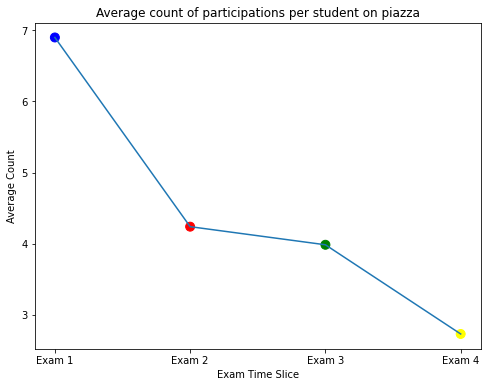

In [ ]:
fig = plt.figure(figsize = (8, 6))
plt.plot(exam_labels, stat_3)
plt.scatter(exam_labels, stat_3, color=['blue', 'red', 'green', 'yellow'], s=80)
plt.xlabel("Exam Time Slice")
plt.ylabel("Average Count")
plt.title("Average count of participations per student on piazza")
plt.show()

In [ ]:
# Distribution of total participation per student
start_4_e1 = e1['uid'].value_counts().to_list()
start_4_e2 = e2['uid'].value_counts().to_list()
start_4_e3 = e3['uid'].value_counts().to_list()
start_4_e4 = e4['uid'].value_counts().to_list()

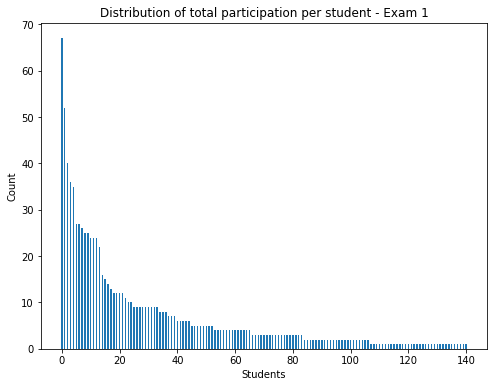

In [ ]:
fig = plt.figure(figsize = (8, 6))
# plt.plot(range(len(start_4_e1)), start_4_e1)
plt.bar(range(len(start_4_e1)), start_4_e1, width=0.5)
plt.xlabel("Students")
plt.ylabel("Count")
plt.title("Distribution of total participation per student - Exam 1")
plt.show()

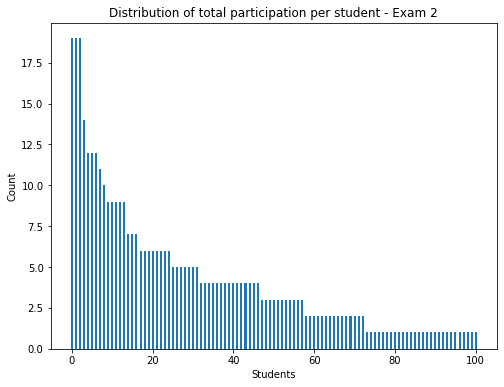

In [ ]:
fig = plt.figure(figsize = (8, 6))
# plt.plot(range(len(start_4_e2)), start_4_e2)
plt.bar(range(len(start_4_e2)), start_4_e2, width=0.5)
plt.xlabel("Students")
plt.ylabel("Count")
plt.title("Distribution of total participation per student - Exam 2")
plt.show()

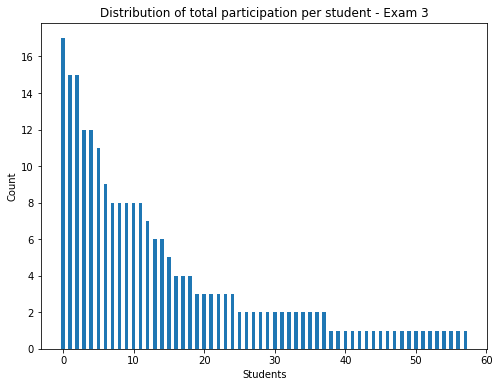

In [ ]:
fig = plt.figure(figsize = (8, 6))
# plt.plot(range(len(start_4_e3)), start_4_e3)
plt.bar(range(len(start_4_e3)), start_4_e3, width=0.5)
plt.xlabel("Students")
plt.ylabel("Count")
plt.title("Distribution of total participation per student - Exam 3")
plt.show()

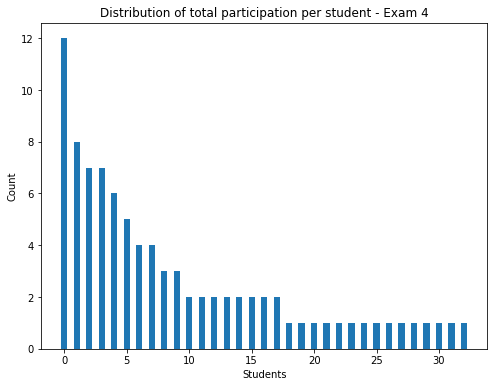

In [ ]:
fig = plt.figure(figsize = (8, 6))
# plt.plot(range(len(start_4_e4)), start_4_e4)
plt.bar(range(len(start_4_e4)), start_4_e4, width=0.5)
plt.xlabel("Students")
plt.ylabel("Count")
plt.title("Distribution of total participation per student - Exam 4")
plt.show()